<a href="https://colab.research.google.com/github/janael-pinheiro/time_series/blob/master/anomaly_detection_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 -q install investpy fbprophet

     |████████████████████████████████| 4.4MB 5.2MB/s 
     |████████████████████████████████| 245kB 41.9MB/s 
     |████████████████████████████████| 5.5MB 46.2MB/s 
     |████████████████████████████████| 512kB 45.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import investpy
from datetime import date
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sns.set_style("whitegrid", {"grid.style":"--"})

In [ ]:
years = 10
stock_name = "AAPL"
country = "United States"

In [ ]:
initial_date = "{0}/{1}/{2}".format(date.today().day, date.today().month, date.today().year-years)

In [ ]:
final_date = date.today().strftime("%d/%m/%Y")

In [ ]:
prices = investpy.get_stock_historical_data(stock=stock_name, from_date=initial_date, to_date=final_date, country=country)

In [ ]:
prices

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-10-18,11.37,11.39,11.22,11.36,1104458624,USD
2010-10-19,10.84,11.21,10.71,11.05,1232760576,USD
2010-10-20,11.04,11.22,10.96,11.09,721624832,USD
2010-10-21,11.16,11.24,10.96,11.05,551457856,USD
2010-10-22,11.04,11.07,10.94,10.98,372775808,USD
...,...,...,...,...,...,...
2020-10-12,120.02,125.16,119.36,124.40,240226768,USD
2020-10-13,125.32,125.32,119.89,121.10,262330448,USD
2020-10-14,120.92,122.99,119.63,121.19,151062304,USD


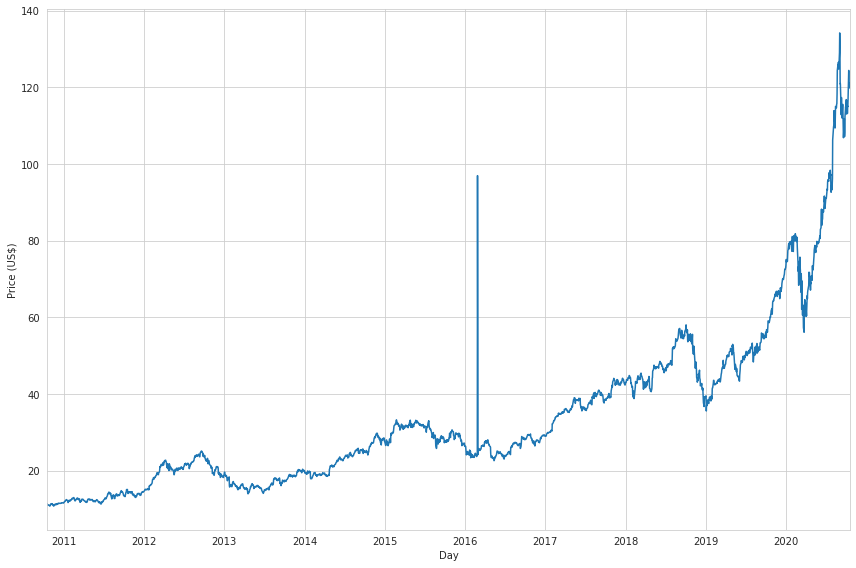

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=prices["Close"])
plt.xlabel("Day")
plt.ylabel("Price (US$)")
plt.xlim(pd.Timestamp(prices.index.min()),pd.Timestamp(prices.index.max()))
plt.grid(True)
plt.tight_layout()

In [ ]:
close_prices = prices["Close"]

<h1>Anomaly detection</h1>

In [ ]:
df = pd.DataFrame()
df["ds"] = close_prices.index.values
df["y"] = close_prices.values

In [ ]:
trainedModel = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, seasonality_mode="additive", interval_width=0.95)

In [ ]:
trainedModel.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
predictions = trainedModel.predict(df)

In [ ]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-10-18,10.646379,1.677084,23.142544,10.646379,10.646379,2.183373,2.183373,2.183373,2.183373,2.183373,2.183373,0.0,0.0,0.0,12.829751
1,2010-10-19,10.658220,2.133504,23.346775,10.658220,10.658220,2.082744,2.082744,2.082744,2.082744,2.082744,2.082744,0.0,0.0,0.0,12.740964
2,2010-10-20,10.670062,2.581338,24.815342,10.670062,10.670062,1.980663,1.980663,1.980663,1.980663,1.980663,1.980663,0.0,0.0,0.0,12.650725
3,2010-10-21,10.681904,0.958527,23.860299,10.681904,10.681904,1.878384,1.878384,1.878384,1.878384,1.878384,1.878384,0.0,0.0,0.0,12.560288
4,2010-10-22,10.693746,1.690953,22.186763,10.693746,10.693746,1.777089,1.777089,1.777089,1.777089,1.777089,1.777089,0.0,0.0,0.0,12.470835


In [ ]:
predictions = predictions[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
predictions["ytrue"] = close_prices.values

In [ ]:
predictions['anomaly'] = np.where((predictions['ytrue'] < predictions['yhat_lower']) | (predictions['ytrue'] > predictions['yhat_upper']), True, False)

<h1>Shows anomalies</h1>

In [ ]:
def createLayout(predictions):

    layout = {'height': 420,
        'width':950,
        'plot_bgcolor': 'white',
          'paper_bgcolor': 'white',
          'margin': {'t':10, 'b':10, 'l':10, 'r':10, 'pad':0},
          'yaxis': {'showgrid': True,
                    'zeroline': True,
                    'mirror': True,
                    'color': '#737373',
                    'linecolor': '#d9d9d9',
                    'gridcolor': '#d9d9d9',
                    'tickformat': '.0f'},
          'xaxis': {'range':[predictions['ds'].min(), predictions['ds'].max()],
                    'autorange': False,
                    'showgrid': True,
                    'zeroline': True,
                    'mirror': True,
                    'color': '#737373',
                    'linecolor': '#d9d9d9',
                    'gridcolor': '#d9d9d9',
                    'type': 'date',
                    'tickformat': '%d %b %y %H:%M',
                    'tickangle': 0,
                    'nticks': 5}}
    return layout

In [ ]:
def plotAnomalies(predictions):

    data = []
    data.append(go.Scatter(x=predictions.query('anomaly == False')['ds'],
                        y=predictions.query('anomaly == False')['ytrue'],
                        mode='markers',
                        marker=dict(color='#000000', size=7),
                        name='Price (US$)',
                        hovertemplate='<b>Price (US$)</b><br>'
                        '<b>Datetime:</b> %{x|%d %b %Y %H:%M:%S}<br>'
                        '<b>Price (US$):</b> %{y: .2f}<extra></extra>'))

    data.append(go.Scatter(x=predictions.query('anomaly == True')['ds'],
                        y=predictions.query('anomaly == True')['ytrue'],
                        mode='markers',
                        marker=dict(color='#e60000', size=7),
                        name='Anomalies',
                        hovertemplate='<b>Anomalies</b><br>'
                        '<b>Datetime:</b> %{x|%d %b %Y %H:%M:%S}<br>'
                        '<b>Price (US$):</b> %{y: .2f}<extra></extra>'))

    data.append(go.Scatter(x=predictions['ds'], y=predictions["yhat_lower"], fill="tonexty", mode='lines', name="Lower threshold", line_color="#00b300"))
    data.append(go.Scatter(x=predictions['ds'], y=predictions["yhat_upper"], fill="tonexty", mode='lines', name="Upper threshold", line_color="#00b300"))

    fig = go.Figure(data=data, layout=createLayout(predictions))
    return fig

In [ ]:
plotAnomalies(predictions)